In [1]:
import torch
import numpy as np
import os
import random
import pandas as pd
from astropy.io import fits
from case_studies.galaxy_clustering.utils import diagnostics
import matplotlib.pyplot as plt
from astropy.visualization import make_lupton_rgb
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from astropy.table import Table

In [2]:
DES_DIR = "/nfs/turbo/lsa-regier/scratch/gapatron/desdr-server.ncsa.illinois.edu/despublic/dr2_tiles"
DES_BANDS = ("g", "r", "i", "z")
DES_SUBDIRS = [d for d in os.listdir(DES_DIR) if d.startswith("DES")]
tiles_per_img = 64

In [3]:
def convert_to_global_idx(tile_idx, gpu_idx):
    num_gpus = 2
    tiles_per_img = 64
    batch_size = 2
    dir_idx = int(num_gpus * (tile_idx // (tiles_per_img / batch_size)) + gpu_idx)
    subimage_idx = [(batch_size * tile_idx + i) % tiles_per_img for i in range(batch_size)]
    return dir_idx, subimage_idx

def convert_to_tile_idx(dir_idx):
    num_gpus = 2
    tiles_per_img = 64
    batch_size = 2
    gpu_idx = dir_idx % num_gpus
    tile_starting_idx = (tiles_per_img / batch_size) * (dir_idx // num_gpus)
    return int(tile_starting_idx), int(gpu_idx)

In [4]:
tile_idx = 0
gpu_idx = 0

dir_idx, subimage_idx = convert_to_global_idx(tile_idx, gpu_idx)
print(f"Directory: {DES_SUBDIRS[dir_idx]}")
print(f"Subimage: {subimage_idx}")

Directory: DES0053-2041
Subimage: [0, 1]


In [5]:
memberships = torch.empty((0,10,10))
output_dir = "/data/scratch/des/dr2_detection_output/run_0"
dir_idx = 10167
tile_starting_idx, gpu_idx = convert_to_tile_idx(dir_idx)
for tile in range(tile_starting_idx, tile_starting_idx + 32):
    file = torch.load(f"{output_dir}/tile_{tile}_gpu_{gpu_idx}.pt")
    memberships = torch.cat((memberships, file["mode_cat"]["membership"].squeeze()), dim=0)

expanded_memberships = torch.repeat_interleave(memberships, repeats=128, dim=1)
expanded_memberships = torch.repeat_interleave(expanded_memberships, repeats=128, dim=2)
expanded_memberships.shape

torch.Size([64, 1280, 1280])

In [ ]:
# gpu 0 : 0, 2, 4, 6, 8, ...
# gpu 1 : 1, 3, 5, 7, 9, ...

# tile_0 : 0, 1             -- image 0
# tile_1 : 2, 3             -- image 0
# tile_2 : 4, 5             -- image 0
# ...
# tile_31 : 62, 63          -- image 0
# tile_32 : 64, 65          -- image 1 (image 2 overall)

# tile_t_gpu_g --> dir_id = 2 * (t // 32) + g
#              --> sub_id = (2*t % 64), (2*t + 1) % 64

In [6]:
def count_num_clusters(dir_idx):
    memberships = torch.empty((0,10,10))
    tile_starting_idx, gpu_idx = convert_to_tile_idx(dir_idx)
    for tile in range(tile_starting_idx, tile_starting_idx + 32):
        file = torch.load(f"{output_dir}/tile_{tile}_gpu_{gpu_idx}.pt")
        memberships = torch.cat((memberships, file["mode_cat"]["membership"].squeeze()), dim=0)
    memberships = torch.repeat_interleave(memberships, repeats=128, dim=1)
    memberships = torch.repeat_interleave(memberships, repeats=128, dim=2)
    return torch.any(memberships.view(memberships.shape[0], -1), dim=1).sum()

In [8]:
num_clusters = pd.read_pickle("/data/scratch/des/num_clusters.pickle")

In [9]:
one_cluster_list = []
for k, v in num_clusters.items():
    if v == 1:
        one_cluster_list.append(k)

In [10]:
np.random.choice(one_cluster_list)

'DES0205+0209'

In [11]:
dir = 'DES0438-2623'
dir_idx = DES_SUBDIRS.index(dir)

In [12]:
memberships = torch.empty((0,10,10))
tile_starting_idx, gpu_idx = convert_to_tile_idx(dir_idx)
for tile in range(tile_starting_idx, tile_starting_idx + 32):
    file = torch.load(f"{output_dir}/tile_{tile}_gpu_{gpu_idx}.pt")
    memberships = torch.cat((memberships, file["mode_cat"]["membership"].squeeze()), dim=0)
memberships = torch.repeat_interleave(memberships, repeats=128, dim=1)
memberships = torch.repeat_interleave(memberships, repeats=128, dim=2)
memberships.shape

torch.Size([64, 1280, 1280])

In [13]:
image_g = torch.tensor(fits.getdata(f"{DES_DIR}/{dir}/{dir}_r4939p01_g_nobkg.fits.fz"))
image_r = torch.tensor(fits.getdata(f"{DES_DIR}/{dir}/{dir}_r4939p01_r_nobkg.fits.fz"))
image_i = torch.tensor(fits.getdata(f"{DES_DIR}/{dir}/{dir}_r4939p01_i_nobkg.fits.fz"))
image_z = torch.tensor(fits.getdata(f"{DES_DIR}/{dir}/{dir}_r4939p01_z_nobkg.fits.fz"))

In [14]:
full_image = torch.stack([image_g, image_r, image_i, image_z], axis=0)
image = full_image.unfold(dimension=1, size=1280, step=1235).unfold(
                dimension=2, size=1280, step=1235
            )
            # Finally obtain (4, 64, 1280, 1280)
image = image.reshape(4, -1, 1280, 1280)
image.shape

torch.Size([4, 64, 1280, 1280])

In [15]:
for i in range(64):
    if memberships[i].sum() > 0.0:
        print(i)

29


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


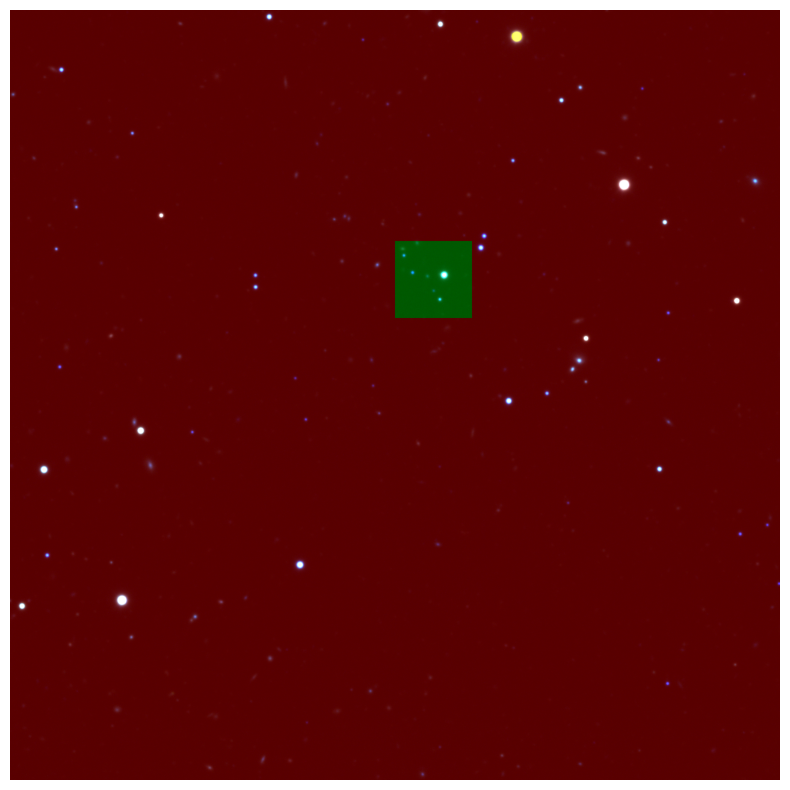

In [16]:
idx = 29
test_out = memberships[idx,:,:]
test_img = image[:3,idx,:,:]
overlay = diagnostics.create_overlay(test_out, tile_size=1)
blended_image = diagnostics.blend_images(test_img.permute(1,2,0), overlay, alpha=0.35, img_crop=0)

plt.figure(figsize=(10,10))
plt.imshow(blended_image, origin="lower")
plt.axis('off')
plt.show()

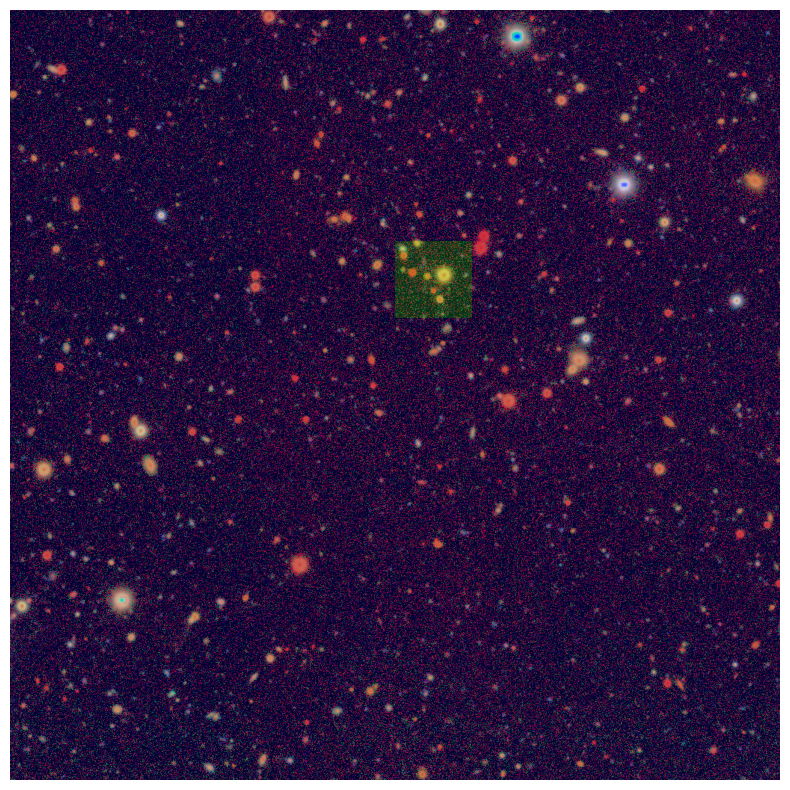

In [17]:
rgb_default = make_lupton_rgb(image[2,idx,:,:], image[1,idx,:,:], image[0,idx,:,:])

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(rgb_default, alpha=1, origin="lower")
ax.imshow(255 * test_out, cmap='winter', alpha=0.2, origin="lower")
ax.set_axis_off()

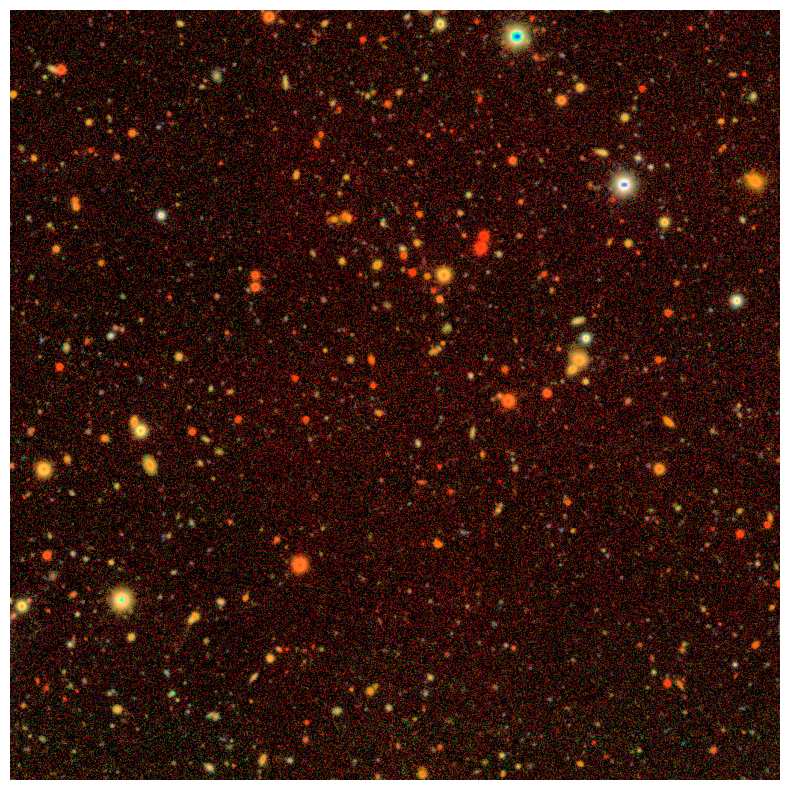

In [19]:
rgb_default = make_lupton_rgb(image[2,idx,:,:], image[1,idx,:,:], image[0,idx,:,:])

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(rgb_default, alpha=1, origin="lower")
ax.set_axis_off()

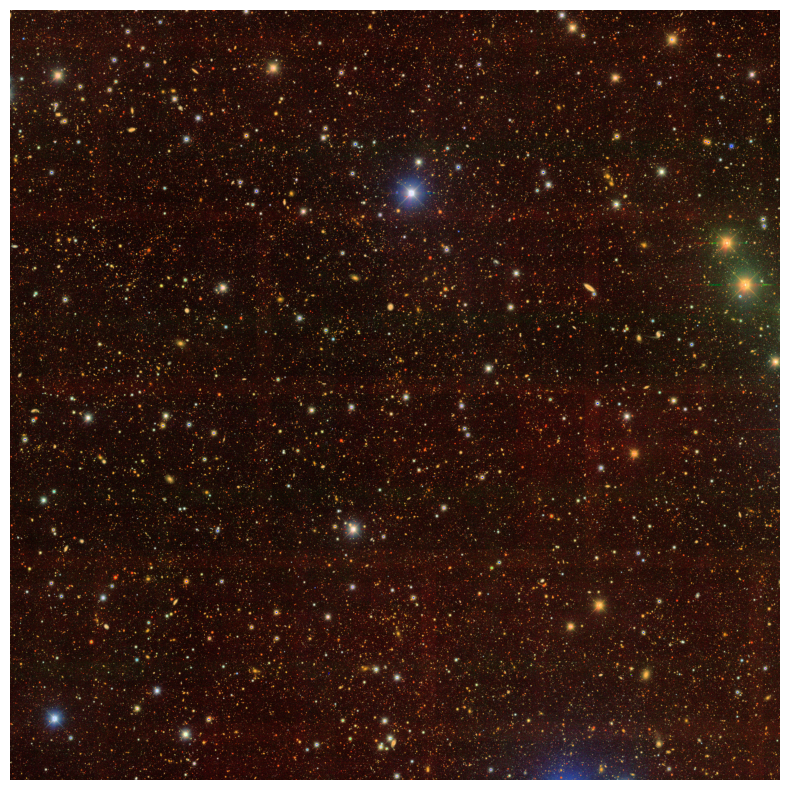

In [21]:
rgb_default = make_lupton_rgb(image_i, image_r, image_g)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(rgb_default, alpha=1, origin="lower")
ax.set_axis_off()

In [22]:
bounding_boxes = pd.read_pickle("/data/scratch/des/bounding_coordinates.pickle")
bounding_boxes[dir]

{'RA_min': 69.217223,
 'RA_max': 70.014204,
 'DEC_min': -26.754155,
 'DEC_max': -26.04028}

In [23]:
redmapper_catalogs = Table(fits.getdata("../data_generation/redmapper_sva1-expanded_public_v6.3_members.fits")).to_pandas()
redmapper_catalogs

ID          RA        DEC         R         P  P_FREE   THETA_I  \
0         1  104.759602 -55.903158  0.868126  0.783947     1.0  1.000000   
1         1  104.804707 -55.886614  1.203799  0.032133     1.0  1.000000   
2         1  104.779776 -55.885828  1.086250  0.855959     1.0  1.000000   
3         1  104.821770 -55.883279  1.312433  0.780496     1.0  1.000000   
4         1  104.811481 -55.872320  1.334219  0.622183     1.0  1.000000   
...     ...         ...        ...       ...       ...     ...       ...   
90674  9058   67.502392 -58.370693  0.328518  0.508214     1.0  0.999999   
90675  9058   67.512681 -58.370300  0.416753  0.050354     1.0  0.999373   
90676  9058   67.515461 -58.368211  0.461415  0.138046     1.0  1.000000   
90677  9058   67.504254 -58.360906  0.479286  0.072485     1.0  1.000000   
90678  9058   67.449636 -58.344708  0.752567  0.230837     1.0  1.000000   

        THETA_R  MAG_AUTO_G  MAGERR_AUTO_G  MAG_AUTO_R  MAGERR_AUTO_R  \
0      1.000000   21.949570       0.021828   20.347677       0.005885   
1      0.694302   21.080441       0.009810   19.955923       0.004091   
2      0.997875   22.052946       0.020068   20.547306       0.005846   
3      0.047996   21.168688       0.015462   19.707525       0.004792   
4      0.017850   21.123981       0.021484   19.915541       0.008251   
...         ...         ...            ...         ...            ...   
90674  1.000000   25.143179       0.226469   23.788034       0.076743   
90675  1.000000   24.359793       0.133894   23.429205       0.066992   
90676  1.000000   24.519791       0.117520   23.343904       0.049114   
90677  1.000000   23.716101       0.067762   22.338913       0.022719   
90678  0.305342   25.739197       0.520324   23.454229       0.074986   

       MAG_AUTO_I  MAGERR_AUTO_I  MAG_AUTO_Z  MAGERR_AUTO_Z  Z_SPEC  \
0       19.803492       0.009052   19.489954       0.010690    -1.0   
1       19.536043       0.007742   19.330839       0.009808    -1.0   
2       20.020580       0.009085   19.715313       0.010825    -1.0   
3       19.179884       0.008525   18.859488       0.009843    -1.0   
4       19.505432       0.015854   19.218428       0.018839    -1.0   
...           ...            ...         ...            ...     ...   
90674   22.617744       0.048809   22.279425       0.067014    -1.0   
90675   22.679384       0.062688   22.327967       0.084922    -1.0   
90676   22.529673       0.041396   22.140692       0.052552    -1.0   
90677   21.479088       0.019162   21.159414       0.025995    -1.0   
90678   22.366840       0.053246   21.949825       0.064760    -1.0   

       COADD_OBJECTS_ID  
0            2924102426  
1            2924104213  
2            2924104247  
3            2924104740  
4            2924105979  
...                 ...  
90674        2945499429  
90675        2945499464  
90676        2945499645  
90677        2945503332  
90678        2945507724  

[90679 rows x 18 columns]

In [28]:
reduced_catalog = redmapper_catalogs[redmapper_catalogs["RA"] < bounding_boxes[dir]["RA_max"]]
reduced_catalog = reduced_catalog[reduced_catalog["RA"] > bounding_boxes[dir]["RA_min"]]
reduced_catalog = reduced_catalog[reduced_catalog["DEC"] < bounding_boxes[dir]["DEC_max"]]
reduced_catalog = reduced_catalog[reduced_catalog["DEC"] > bounding_boxes[dir]["DEC_min"]]
reduced_catalog

Empty DataFrame
Columns: [ID, RA, DEC, R, P, P_FREE, THETA_I, THETA_R, MAG_AUTO_G, MAGERR_AUTO_G, MAG_AUTO_R, MAGERR_AUTO_R, MAG_AUTO_I, MAGERR_AUTO_I, MAG_AUTO_Z, MAGERR_AUTO_Z, Z_SPEC, COADD_OBJECTS_ID]
Index: []